In [1]:
from helpers.preprocess import DataProcessor
from helpers.explore import ExploreData
from helpers.train_model import TrainModels
import pandas as pd
import seaborn as sns

In [2]:
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_columns = 100

## Read in Data

In [3]:
X = pd.read_csv('./data/train_values.csv', index_col='building_id')
X2 = pd.read_csv('./data/test_values.csv', index_col='building_id')

y = pd.read_csv('./data/train_labels.csv', index_col='building_id')
df = y.merge(X, left_index=True, right_index=True)

In [4]:
print(X.shape)
X.head()

(260601, 38)


,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [5]:
print(y.shape)
y.head()

(260601, 1)


,damage_grade
building_id,
802906,3
28830,2
94947,3
590882,2
201944,3


In [6]:
binary_cols = [col for col in X.columns if 'has_' in col]
int_cols = [col for col in X.columns if 'count_' in col or '_percentage' in col or 'age' in col]
dum_cols = [col for col in X.columns if col not in (int_cols + binary_cols)]

In [7]:
X.loc[:,int_cols].describe()

,count_floors_pre_eq,age,area_percentage,height_percentage,count_families
count,260601.00,260601.00,260601.00,260601.00,260601.00
mean,2.13,26.54,8.02,5.43,0.98
std,0.73,73.57,4.39,1.92,0.42
min,1.00,0.00,1.00,2.00,0.00
25%,2.00,10.00,5.00,4.00,1.00
50%,2.00,15.00,7.00,5.00,1.00
75%,2.00,30.00,9.00,6.00,1.00
max,9.00,995.00,100.00,32.00,9.00


1390 buildings have 995 recorded for their age


<AxesSubplot:>

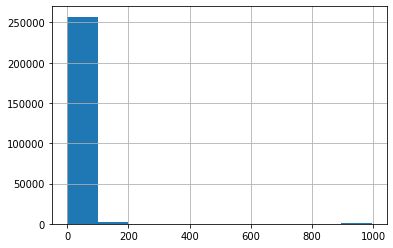

In [8]:
cnt_995 = len(df[df['age']==995])
print(f'{cnt_995} buildings have 995 recorded for their age')
df.age.hist()

<AxesSubplot:>

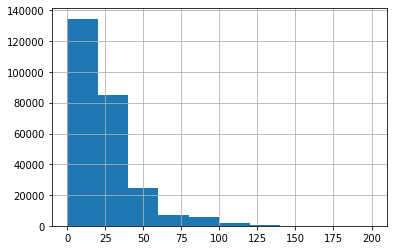

In [9]:
no_995 = df[df['age'] != 995]
no_995.age.hist()

The tallest building in the data is 9 floors tall, which indicates that "skyscrapers" or "high rises" were not included in the data. This shows that there are not extreme outliers to be concerned about. This is likewise true for the number of families residing in the building.

The age range shows values between 0-995 years old. Since 995 is represented several times in the data and the likelihood of a building that age being so small, I assume that it is used in place of nulls. To avoid causing mathematical misinterpretation of the field, I will replace the value 995 with null and then bin the data. This will allow the model to understand the age range without sacrificing information about null values.

In [10]:
ExploreData.evaluate_relationships(df, int_cols)

median  mean   std
variable            damage_grade                    
age                 1               5.00 17.32 83.68
                    2              15.00 27.34 74.93
                    3              20.00 27.82 67.68
area_percentage     1               8.00  9.72  6.29
                    2               7.00  8.03  4.26
                    3               7.00  7.50  3.79
count_families      1               1.00  0.92  0.50
                    2               1.00  0.98  0.40
                    3               1.00  1.01  0.42
count_floors_pre_eq 1               2.00  1.84  0.83
                    2               2.00  2.13  0.72
                    3               2.00  2.21  0.69
height_percentage   1               5.00  5.15  2.51
                    2               5.00  5.43  1.83
                    3               5.00  5.52  1.87

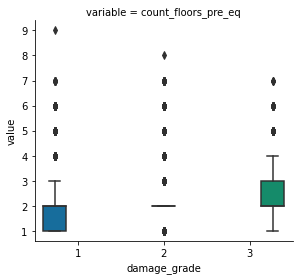

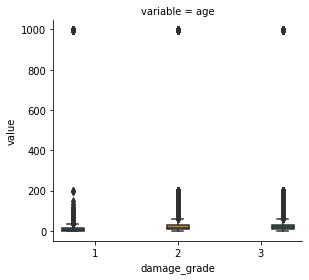

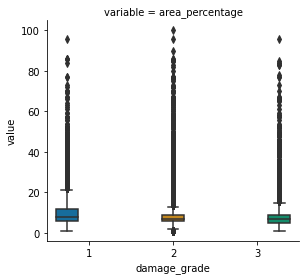

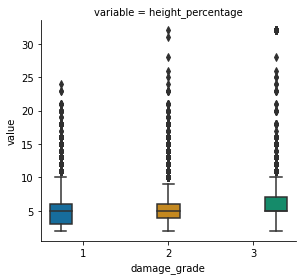

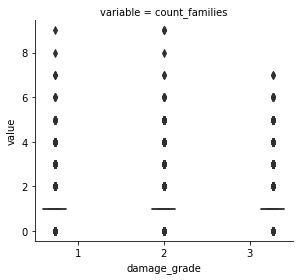

In [11]:
sm = df.melt(id_vars='damage_grade',value_vars=int_cols)

for col in int_cols:
    sm_col = sm[sm['variable']==col]
    
    sns.catplot(kind='box', data=sm_col, x='damage_grade', y='value', col='variable', 
                hue='damage_grade',palette='colorblind',col_wrap=2,
                height=4,aspect=1)

Age shows the strongest relationship with damage grade. The older the building, the more severe the earthquake damage appears to be.

## Target Value Exploration

In [12]:
class_values = pd.DataFrame(y.value_counts(),columns=['count'])
class_values['perc'] = round(class_values['count'] / len(y) * 100, 2)
class_values

,count,perc
damage_grade,,
2,148259,56.89
3,87218,33.47
1,25124,9.64


<AxesSubplot:xlabel='damage_grade'>

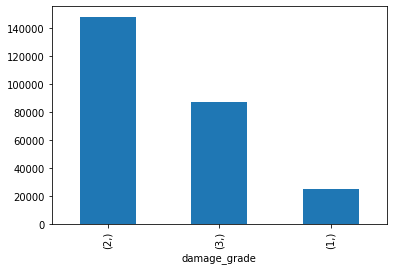

In [13]:
class_values['count'].plot(kind='bar')

Buildings with low relative damage are the least common values in the dataset. Medium damage is the most common. Imbalanced datasets can cause error in model predictions. I should consider rebalancing the data if this appears to be problematic downstream.

## Process Data

In [14]:
processor = DataProcessor(X, y, X2)
X_train, X_test, y_train, y_test, X_val = processor.process()

[INFO] Columns have been transformed into their appropriate data types
[INFO] Value 995 has been replaced with nan in ['age']
[INFO] Columns [] have been dropped from the data frame
[INFO] Data has been split into training & test sets
[INFO] X_train = (182420, 38)
[INFO] y_train = (182420, 1)
[INFO] X_test = (78181, 38)
[INFO] y_test = (78181, 1)
[INFO] 3 bins were created for age columns and applied to test set
[INFO] Rare values of geo_level_3_id have been grouped into a category titled "rare"
[INFO] 12 columns have been dummied: ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'age', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'legal_ownership_status']
[INFO] X_train = (182420, 4884)
[INFO] X_test = (78181, 4884)
[INFO] val_data = (86868, 4884)
[INFO] 12 columns were dropped for being non-unique: ['geo_level_2_id_100', 'geo_level_2_id_115', 'geo_level_2_id_1158', 'geo_level_2_id_1263', 'ge

## Train Models

In [15]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import f1_score

### Test Basic Models

In [16]:
models = {}

model = RandomForestClassifier(random_state=0,n_jobs=-1)
models['Random Forest'] = model

model = LogisticRegression(random_state=0,n_jobs=-1)
models['Logistic Regression'] = model

model = BernoulliNB()
models['Naive Bayes'] = model

model = GradientBoostingClassifier(random_state=0)
models['GBM'] = model

model = SGDClassifier(random_state=0)
models['SGD'] = model

In [17]:
trainer = TrainModels(models, X_train, X_test, y_train, y_test)

print('Results from training models on the original data')
model_results = trainer.train_models()

Results from training models on the original data
F1 Score for Random Forest is 0.7176551847635615
F1 Score for Logistic Regression is 0.7337716324938284
F1 Score for Naive Bayes is 0.6785919852649621
F1 Score for GBM is 0.6894769828986582
F1 Score for SGD is 0.7202773052276129


### Tune Most Promising Models

In [18]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#### Logistic Regression

In [19]:
log_grid = {
    'penalty': ['l1','l2','elasticnet',None],
    'class_weight': [None, 'balanced'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'C': [0.001, 0.01, 0.10, 0.25, 0.50, 0.75, 1.0],
    'multi_class': ['ovr', 'multinomial']
}

‘newton-cg’ - [‘l2’, ‘none’]

‘lbfgs’ - [‘l2’, ‘none’]

‘liblinear’ - [‘l1’, ‘l2’]

‘sag’ - [‘l2’, ‘none’]

‘saga’ - [‘elasticnet’, ‘l1’, ‘l2’, ‘none’]

In [ ]:
newton_cg_grid = {
    'penalty': ['l2',None],
    'class_weight': [None, 'balanced'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'C': [None,0.001, 0.01, 0.10, 0.25, 0.50, 0.75, 1.0],
    'multi_class': ['ovr', 'multinomial']
}